In [1]:
%run ./tools.ipynb

In [2]:
# inversion configurations
year        = 2017
assim_month = 2      # first month to assimilate observation, start from 3, Mar
lag_window  = 3      # months
nx          = 67     # number of tagged tracers, same as number of masks
mode        = 'N'    # OCO-2 Nadir only
mod_err     = 1.5    #1.5 # model/transport error, unit: ppm
land_prior_err  = 0.5 #0.5 # intial prior error, unitless, multiply biospheric flux for actual prior error
ocean_prior_err = 0.3
snow_prior_err  = 0.1

tag_case_name = 'CO2-TC67-' + str(year) + '-'

# full CO2 simulation directory
top_dir = '/scratch/local/msadiq/rundir/'
#top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + str(year) + '/'

name_month = short_name_of_month(assim_month) # Jan, Feb, Mar, ...
# read in data from current directory, analyze
curr_dir = top_dir+ str(year) + '/CO2-' + str(year) + '/nd51/' + name_month + '2018/'

# output in next directory
if assim_month == 12:
    next_dir = top_dir+ str(year+1) + '/CO2-' + str(year+1) + '/nd51/' + short_name_of_month(1) + '/'
else:
    next_dir = top_dir+ str(year) + '/CO2-' + str(year) + '/nd51/' + short_name_of_month(assim_month+1) + '/'
print(curr_dir)


/scratch/local/msadiq/rundir/2017/CO2-2017/nd51/Feb2018/


In [3]:
%%time
### this cell could do all post-processing for a case, over a few months, or a month
year = 2018

for imonth in range(assim_month-lag_window+1,assim_month+1):
    
    if imonth < 1: 
        imonth += 12
        iyear = year - 1
    else: iyear = year
        
    bpch_to_nc_mass(data_dir = curr_dir,
                        year = iyear,
                        month = imonth)

    combine_daily_to_one(data_dir = curr_dir,
                         year = iyear,
                         month = imonth,
                         str1 = 'ts_satellite.',
                         str2 = '.nc')

    flatten_4d_to_2d(data_dir = curr_dir,
                         year = iyear,
                         month = imonth,
                         str1 = 'ts_satellite.',
                         str2 = '.nc')
    
    interpolate_model_to_satellite(mod_dir = curr_dir, 
                                       sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
                                       year = iyear, 
                                       month = imonth, 
                                       str1_mod = '2d_ts_satellite.', 
                                       str1_sat = '2d_OCO2_extract_')
    

converted daily bpch outputs to netcdf format
created ts_satellite.201712.nc
created 2d_ts_satellite.201712.nc
interpolation began
SpeciesConc_CO2 done
created interpolated_2d_ts_satellite.201712.nc
converted daily bpch outputs to netcdf format
created ts_satellite.201801.nc
created 2d_ts_satellite.201801.nc
interpolation began
SpeciesConc_CO2 done
created interpolated_2d_ts_satellite.201801.nc
converted daily bpch outputs to netcdf format
created ts_satellite.201802.nc
created 2d_ts_satellite.201802.nc
interpolation began
SpeciesConc_CO2 done
created interpolated_2d_ts_satellite.201802.nc
CPU times: user 1min 30s, sys: 3.43 s, total: 1min 33s
Wall time: 1min 33s


R is: 0.59  RMSE is:  2.17
R is: 0.69  RMSE is:  2.68
R is: 0.74  RMSE is:  3.09


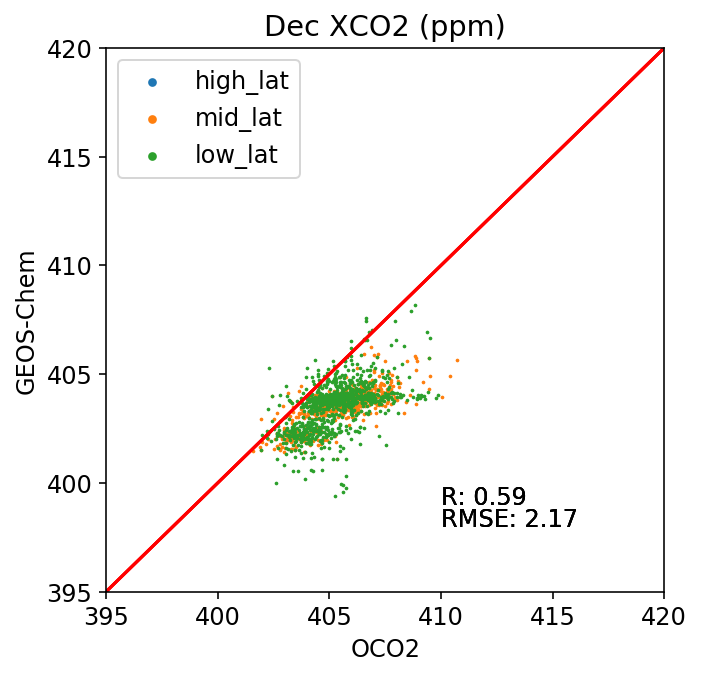

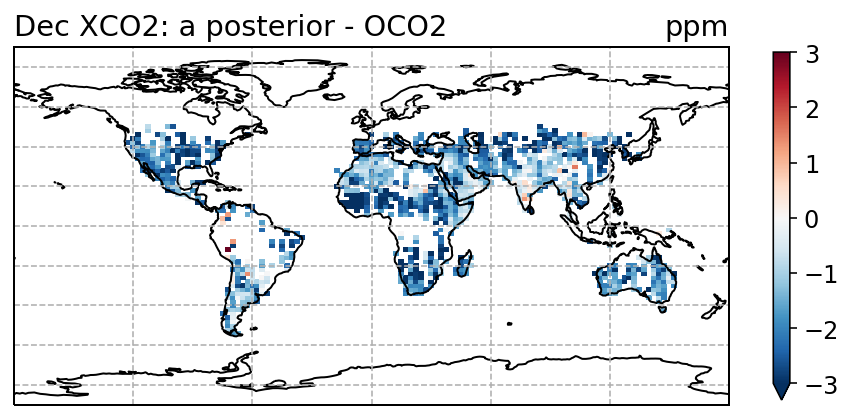

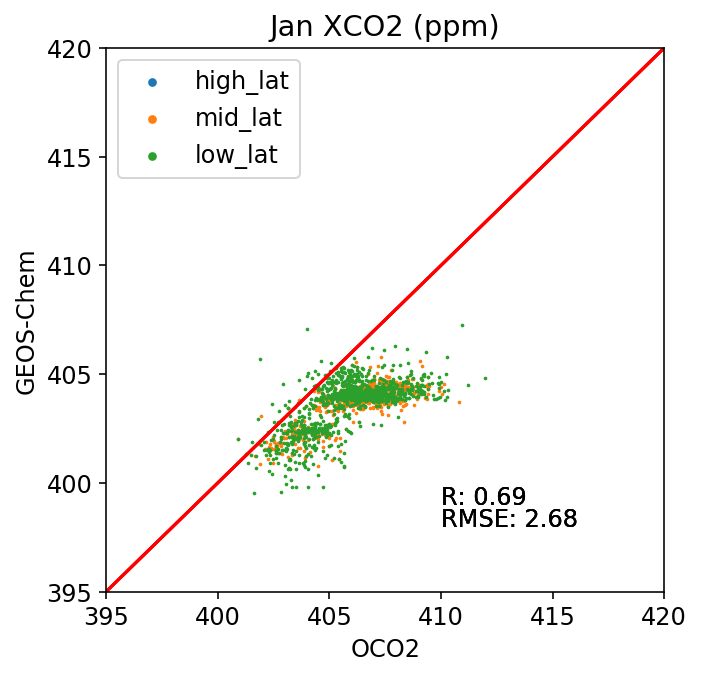

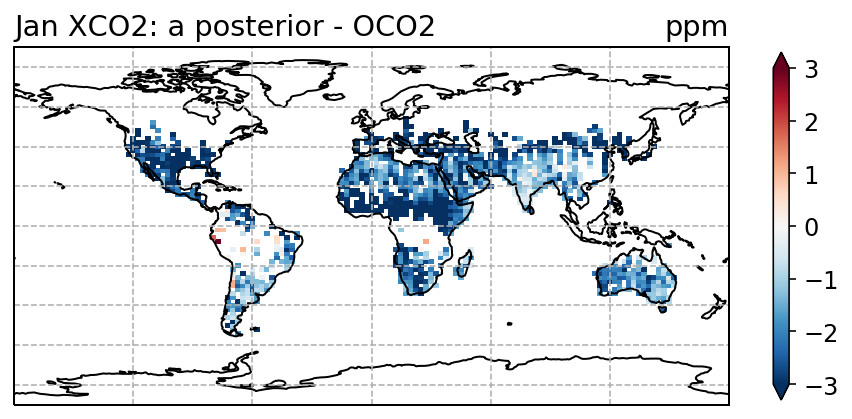

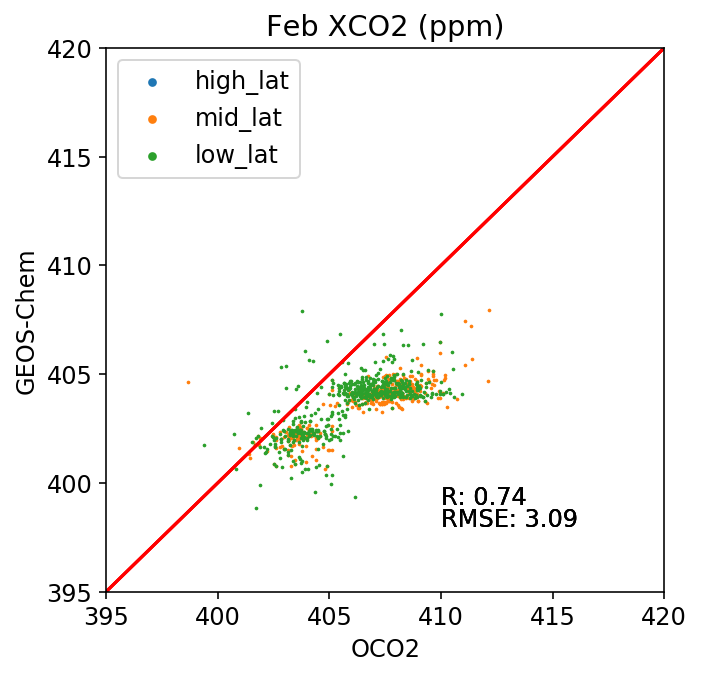

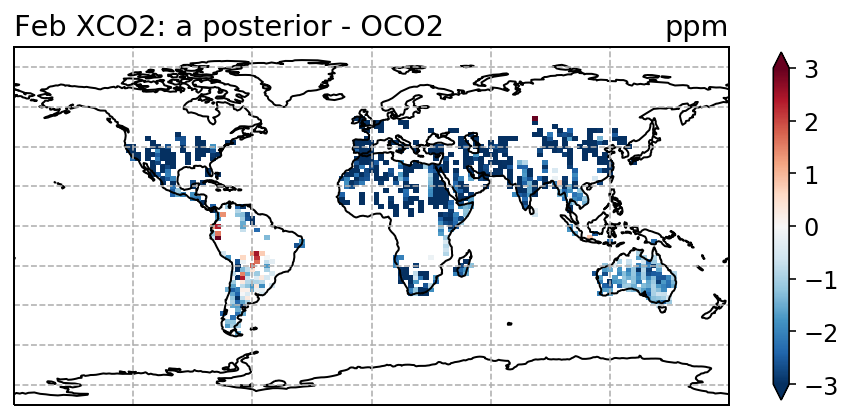

In [4]:
year = 2018

for imonth in range(assim_month - lag_window + 1,assim_month+1):
    
    if imonth < 1: 
        imonth += 12
        iyear = year - 1
    else: iyear = year
     
    compare_XCO2(mod_dir = curr_dir, 
                 sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
                 year = iyear, 
                 month = imonth, 
                 str1_mod = 'interpolated_2d_ts_satellite.', 
                 str1_sat = '2d_OCO2_extract_',
                 mode = 'N')


In [5]:
%run bio_flux_functions_TransCom.ipynb

year = 2018

input_dir = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/'
if year == 2016 and assim_month == 3:
    f1 = input_dir + 'NEE.Liang.2016.nc'
    f2 = input_dir + 'Taka2009_CO2_Monthly.nc'
elif assim_month == 1:
    f1 = input_dir + 'NEE.Liang.2016.updated.' + str(year-1) + '.' + short_name_of_month(12) + '.nc'
    f2 = input_dir + 'Taka2009_CO2_Monthly.updated.' + str(year-1) + '.' + short_name_of_month(12) + '.nc'
else:
    f1 = input_dir + 'NEE.Liang.2016.updated.' + str(year) + '.' + short_name_of_month(assim_month-1) + '.nc'
    f2 = input_dir + 'Taka2009_CO2_Monthly.updated.' + str(year) + '.' + short_name_of_month(assim_month-1) + '.nc'
print(f1)
print(f2)
monthly_bio_flux = regional_monthly_sink(f1, f2)


/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.updated.2018.Jan.nc
/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/Taka2009_CO2_Monthly.updated.2018.Jan.nc
annual total of bio fluxes: -0.180246675456
after summing up monthly:  -0.18024462000872726
after regridding:  -0.18019319807999998
Total annual sink (PgC/year):  -1.177872186065707


In [13]:
# initial prior error
del_X_f = np.diag(np.repeat(land_prior_err,nx))
for i in range(55, nx-1): 
    del_X_f[i,i] = ocean_prior_err # ocean and low emission regions
del_X_f[nx-1,nx-1] = snow_prior_err # snow region

# prior error, read in from previous assimilation (if any)
if year == 2016 and assim_month == 3:
    del_X_lag = np.zeros((nx*lag_window,nx*lag_window))
    for i in range(lag_window): 
        del_X_lag[i*nx:(i+1)*nx,i*nx:(i+1)*nx] = del_X_f #[nx*nlag, nx*nlag], diag,
else:        
    del_X_lag = np.loadtxt(curr_dir + "prior_error_" + short_name_of_month(assim_month) + ".txt")
    
print('actual:', np.diag(del_X_lag))


actual: [0.49387426 0.49028212 0.48395538 0.49250948 0.49519812 0.45400751
 0.47154228 0.45750684 0.44718482 0.47557465 0.47110788 0.4846147
 0.48560315 0.46818009 0.46724474 0.48794423 0.44697894 0.44430217
 0.44590534 0.46078923 0.48697844 0.48764178 0.48541031 0.4676196
 0.42076865 0.47521226 0.48961054 0.47955416 0.47817719 0.47264096
 0.48890425 0.48812658 0.46873726 0.47975304 0.49417285 0.45278599
 0.48831928 0.43042165 0.42951967 0.45563313 0.42355191 0.47632246
 0.48893082 0.49262545 0.49250309 0.49403389 0.49407897 0.49366311
 0.47624203 0.47544597 0.45057712 0.46973703 0.46342159 0.4763453
 0.48200411 0.28868164 0.29935605 0.29596462 0.29613377 0.29453844
 0.29781421 0.29839201 0.29882737 0.29933658 0.29900537 0.29412427
 0.09998118 0.49678062 0.49483907 0.49611095 0.49723284 0.49718359
 0.48017882 0.48967464 0.48176797 0.4636133  0.485081   0.47808915
 0.4923475  0.48891001 0.48203761 0.46962384 0.48891655 0.48210529
 0.45739594 0.4503333  0.4633969  0.49280667 0.48993127 0

/scratch/local/msadiq/rundir/2017/CO2-TC67-2017-12/nd51/
/scratch/local/msadiq/rundir/2018/CO2-TC67-2018-01/nd51/
/scratch/local/msadiq/rundir/2018/CO2-TC67-2018-02/nd51/
Dec adjustment: -0.01
Jan adjustment: 0.20
Feb adjustment: 0.04
y diff before: -2.71
y diff after: -0.71
R1 is: 0.74  RMSE1 is:  3.09
R2 is: 0.74  RMSE2 is:  1.67


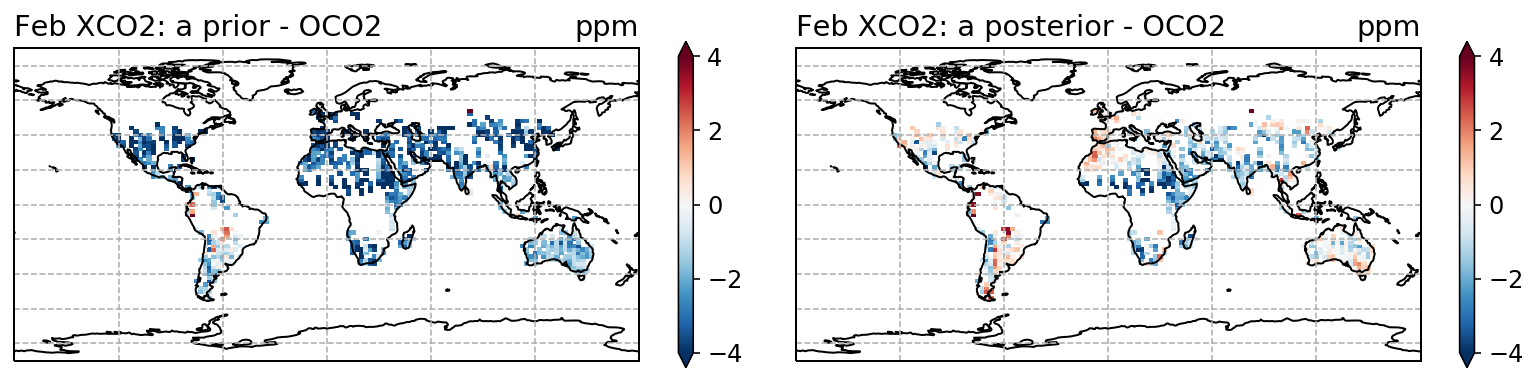

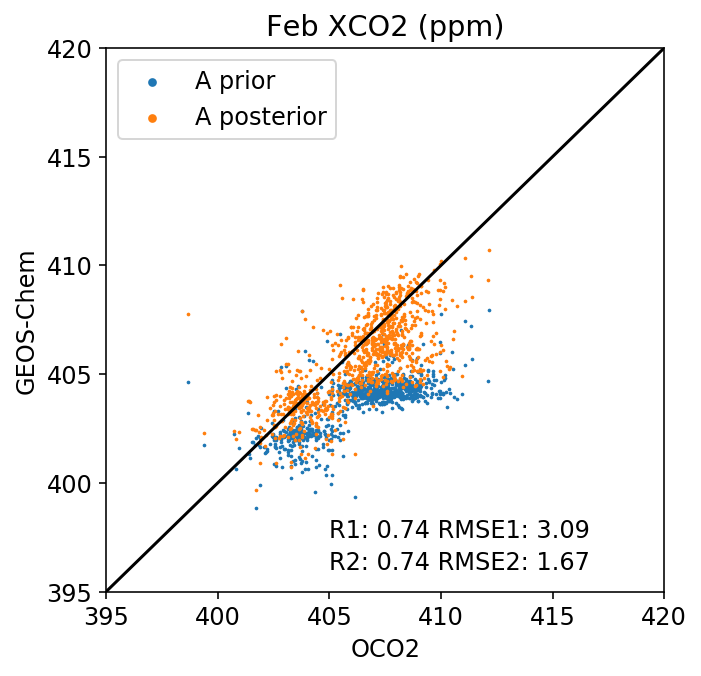

In [14]:
# start of inversion calculation:
# 1, read in from full CO2 simulations

xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
ds_xco2 = xr.open_dataset(curr_dir + xco2_file)
xco2_oco2  = ds_xco2['xco2_oco2']  # XCO2 from OCO-2
xco2_model = ds_xco2['xco2_model'] # XCO2 from model
xco2_error = ds_xco2['xco2_error'] # measurement error from OCO-2
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']

# reduce the size of above arrays and matrices, from ~400k to <3k
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values   # index for slicing
nobs = len(ind) # number of obs in this month
# get slices of arrays
diff_slice = diff[ind].values            # [nobs], 1-3k per month
lat_slice = ds_xco2.lat[ind]
lon_slice = ds_xco2.lon[ind]
xco2_mod_slice = xco2_model[ind]
xco2_oco_slice = xco2_oco2[ind]
xco2_error_slice = xco2_error[ind].values 

# observation error
obs_error = np.zeros((nobs,nobs))  # [nobs,nobs], diagonally store obs error
for idiag in range(nobs):
    obs_error[idiag, idiag] = (0.5*xco2_error_slice[idiag])**2 + mod_err**2
    # measurment error from oco2
    # model error and representation error = 2.5 for land
        
# delta y0
del_Y = np.empty((nobs,nx*lag_window))   # [nobs, nx*lag_window]
del_Y[:] = np.nan

# 2, read in tag runs
for itmp in range(lag_window):
    ilag_month = assim_month - lag_window + itmp + 1
    if ilag_month < 1: 
        ilag_month = ilag_month + 12
        iyear = year - 1
    else: iyear = year
    tag_case_name = 'CO2-TC67-' + str(iyear) + '-'
    ens_dir = top_dir + str(iyear) + '/' + tag_case_name + month_string(ilag_month) + '/nd51/'
    print(ens_dir)
    delta_y0_file = 'delta_y0_model_N_' + str(assim_month) + '.nc'
    # open datasets
    ds_delta_y0 = xr.open_dataset(ens_dir + delta_y0_file)
    varnames = list(ds_delta_y0.data_vars.keys())  # list of variable name
    needed_vars = [i for i in varnames if i.startswith('X_SpeciesConc_CO2Tag')] # species var names
    # read variables
    for itag, ivar in enumerate(needed_vars):
        del_Y[:,itag+nx*itmp] = ds_delta_y0[ivar][ind].values # column order: assim_month - 2, assim_month - 1, assim_month

del_Y0 = del_Y
del_Y = np.dot(del_Y, del_X_lag)   
# calculation of posterior
del_Y_tran = np.matrix.transpose(del_Y)     # del_y transpose [nx*lag_window,nobs]
first      = np.matmul(del_Y,del_Y_tran)    # del_y dot del_y_tran [nobs,nobs]
second     = np.linalg.inv(first+obs_error) # (Y*Yt + R)^-1 [nobs,nobs], dominated by second term, issue???
third      = np.matmul(del_Y_tran,second)   # Yt*(Y*Yt + R)^-1 [nx*lag_window,nobs]
k_e        = np.matmul(del_X_lag,third)     # kalman gain, k_e = X_f*Yt*(Y*Yt + R)^-1 [nx*lag_window,nobs]
adjust     = np.matmul(k_e, diff_slice)     # adjustment to prior, k_e*(yobs - ym)  [nx*lag_window]

#update = adjust * monthly_bio_flux[assim_month-lag_window:assim_month].flatten()

# here for cross year assimilation
monthly_bio_flux_subset = np.vstack((monthly_bio_flux[-1:,:], monthly_bio_flux[0:2,:]))
update = adjust * monthly_bio_flux_subset.flatten()
# monthly updates
for i in range(lag_window):
    print(short_name_of_month(assim_month - lag_window + i + 1), 'adjustment: {:.2f}'.format(sum(update[i*nx:(i+1)*nx])))

# update Y matrix
diff_new = diff_slice - np.dot(del_Y0,adjust) # [nobs], ppm
plot_xco2_diff(diff_slice, diff_new, lat_slice, lon_slice, assim_month, curr_dir)

# transformation matrix to update prior
fourth = np.identity(nx*lag_window) - np.matmul(third, del_Y)
transform_mat = sp.sqrtm(fourth)
del_X_lag = np.matmul(del_X_lag, transform_mat)

# update del_X_lag and use it in next assimilation
del_X_updated = np.zeros((nx*lag_window,nx*lag_window))
del_X_updated[:(lag_window-1)*nx, :(lag_window-1)*nx] = del_X_lag[nx:,nx:]
del_X_updated[(lag_window-1)*nx:, (lag_window-1)*nx:] = del_X_f


In [15]:
# cost function
# J = (x-x_b)_transpose * B * (x-x_b) + (y-h(x))_transpose * R * (y-h(x))
first_half = 0.
second_half = np.dot(np.dot(np.matrix.transpose(diff_slice),np.linalg.inv(obs_error)), diff_slice)
J = first_half + second_half
print('before inversion cost of x:', first_half)
print('before inversion cost of y:', second_half)

x_diff = update # x - prior
B = del_X_lag # prior error covariance matrix 
first_half = np.dot(np.dot(np.matrix.transpose(x_diff),np.linalg.inv(B)), x_diff)
second_half = np.dot(np.dot(np.matrix.transpose(diff_new),np.linalg.inv(obs_error)), diff_new)
J = first_half + second_half
print('after inversion cost of x:', first_half)
print('after inversion cost of y:', second_half)


before inversion cost of x: 0.0
before inversion cost of y: 3478.23665141745
after inversion cost of x: 0.01941847331731035
after inversion cost of y: 1020.7362506262165


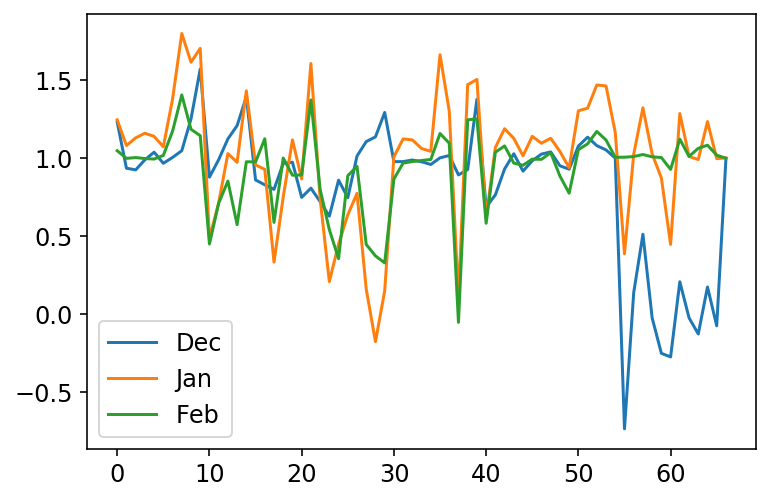

In [16]:
# use this to update biospheric flux in total CO2 simulations
scale_array = 1+adjust
scale_lag = scale_array.reshape(lag_window,nx) # 2d

#scale_lag = np.flip(scale_lag, axis = 0) # flip?

for i in range(lag_window): 
    plt.plot(scale_lag[i], label = short_name_of_month(assim_month - lag_window + i + 1))
plt.legend()

annual total of bio fluxes: -0.180246675456
after summing up monthly:  -0.18024462000872726
after regridding:  -0.18019319807999998
CPU times: user 38.1 s, sys: 272 ms, total: 38.4 s
Wall time: 38.4 s


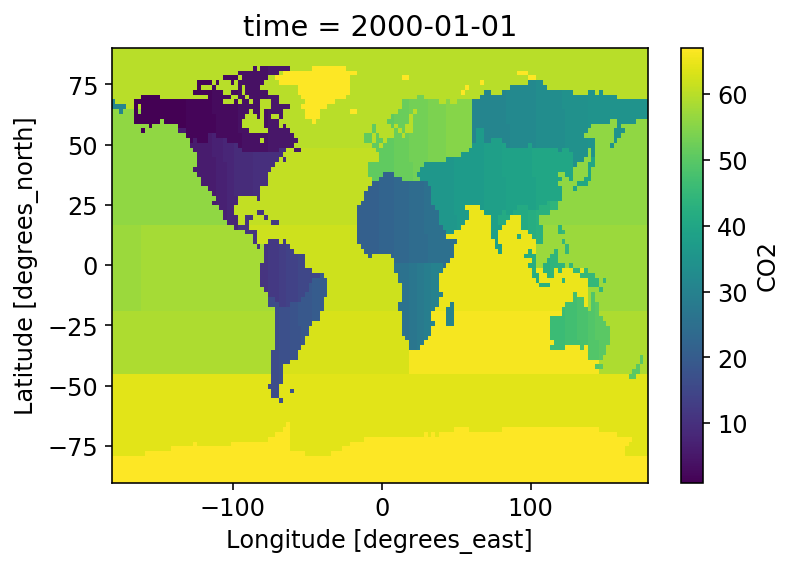

In [17]:
%%time

# monthly fluxes of sinks
dr_sink = monthly_sink(f1, f2) # (12,144,91)

# use TransCom masks
fname = '/geos/u73/msadiq/GEOS-Chem/MASKS/MASK_TC67_1x1.nc'
ds_tc = xr.open_dataset(fname)
dr_mask = ds_tc['transcom_regions']
    
dr_flux_mask = dr_sink[0,:,:].copy()
dr_flux_mask[:,:] = 0.
for ilon, lon in enumerate(dr_flux_mask['lon'].values):
    for ilat, lat in enumerate(dr_flux_mask['lat'].values):
        dr_flux_mask[ilat,ilon] = dr_mask.sel(lat = lat, lon = lon, method="nearest")
        
dr_flux_mask.plot()


In [18]:
%%time
# make scaling maps for each month
scale_map = dr_sink[0:lag_window,:,:].copy()
scale_map[:,:,:] = 0. # scale map, [lag_window, lat, lon]

for imonth in range(lag_window):
    for ilat in range(len(scale_map.lat)):
        for ilon in range(len(scale_map.lon)):
            if np.isnan(dr_flux_mask[ilat,ilon].values): scale_map[imonth,ilat,ilon] = scale_lag[imonth,-1] # last one, ocean
            else: 
                mask_nm = int(dr_flux_mask[ilat,ilon].values)
                scale_map[imonth,ilat,ilon] = scale_lag[imonth,mask_nm-1] # mask number from 1 to 21


CPU times: user 32.4 s, sys: 7.88 ms, total: 32.4 s
Wall time: 32.4 s


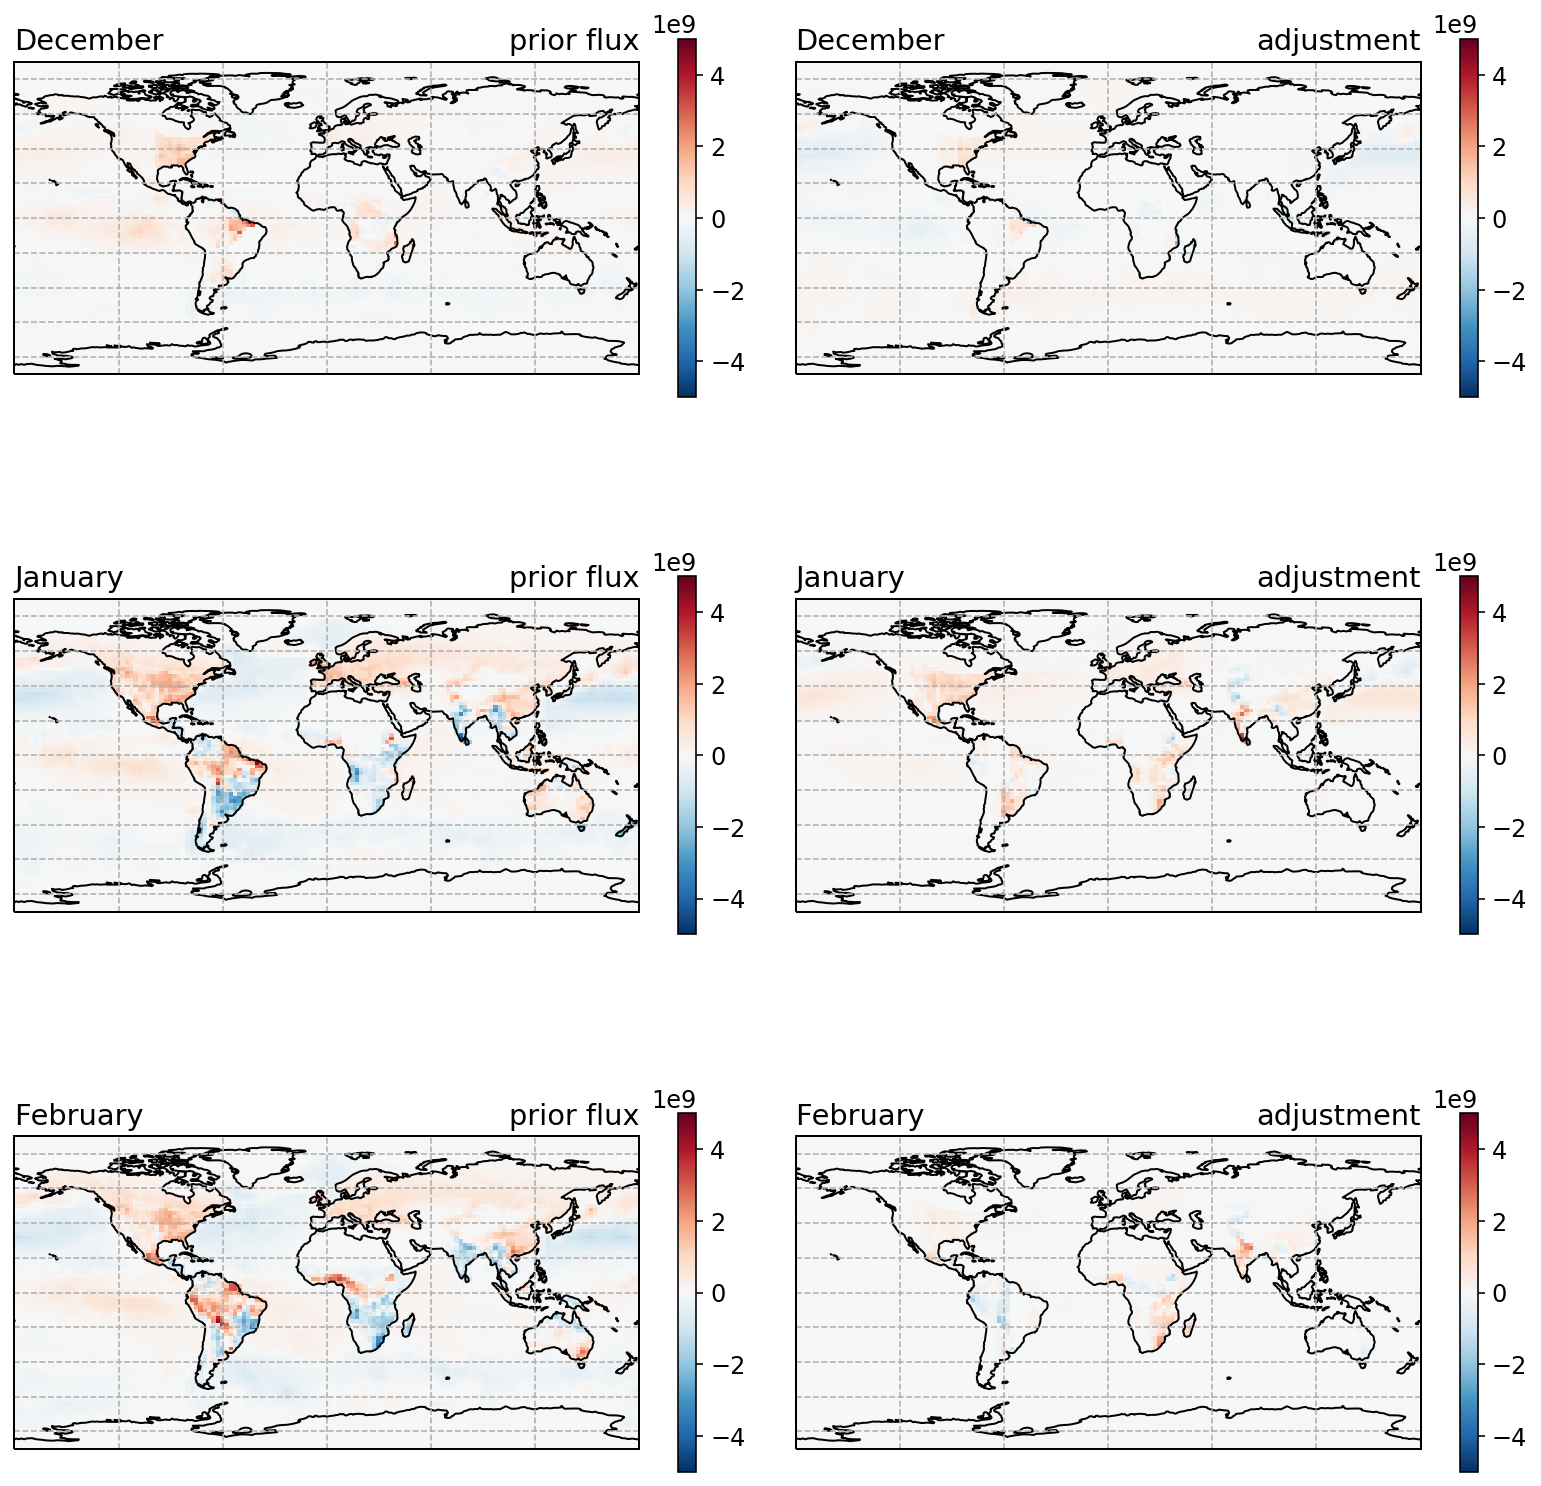

In [19]:
# multiply this scale map to bio flux
# plot updates during lag window
fig, axes = plt.subplots(3, 2, 
                         figsize=[14, 14], 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'hspace': 0.2, 'wspace': 0})

# monthly biospheric flux
for i in range(lag_window):
     
    dr_sink[assim_month - lag_window + i,:,:].plot(ax=axes[i,0], 
                    vmax = 5e9,
                    vmin = -5e9,
                    cmap = 'RdBu_r',
                    add_labels = False,
                    cbar_kwargs={'shrink': 0.8})
    axes[i,0].set_title(long_name_of_month(assim_month - lag_window + i + 1), loc='left')
    axes[i,0].set_title('prior flux', loc='right')
    axes[i,0].coastlines()
    axes[i,0].gridlines(linestyle = '--')
    
# adjustments
for i in range(lag_window):
    adjust_abs = dr_sink[assim_month - lag_window + i,:,:]*(scale_map[i,:,:]-1)
    adjust_abs.plot(ax = axes[i,1],
                            vmax = 5e9,
                            vmin = -5e9,
                            cmap = 'RdBu_r',
                            add_labels = False,
                            cbar_kwargs={'shrink': 0.8})

    axes[i,1].set_title(long_name_of_month(assim_month - lag_window + i + 1), loc='left')
    axes[i,1].set_title('adjustment', loc='right')
    axes[i,1].coastlines()
    axes[i,1].gridlines(linestyle = '--')
    
#fig.savefig(mod_dir  + 'flux_scaling.' + short_name_of_month(assim_month) + '.update.png', dpi = 300)


In [20]:
# update oceanic flux
ds = xr.open_dataset(f2)
data = ds['CO2'].copy()
months = np.arange('2000-01', '2001-02', dtype='datetime64[M]')
#for i in range(lag_window):
#    imonth = assim_month - lag_window + i
for imonth in [-1]:
    if imonth <= 0: imonth += 12
    before = data.sel(time = months[imonth])
    after = data.sel(time = months[imonth])*scale_map[imonth-10,:,:]
    # assign this new subset into dataarray
    time_dim = before.time
    print(time_dim.values)
    data.loc[dict(time = time_dim)] = after
ds_output = data.to_dataset(name = 'CO2')
ds_output.attrs = ds.attrs

ds_output.to_netcdf(input_dir + 'Taka2009_CO2_Monthly.updated.' + str(year) + '.' + name_month + '.nc')


2000-12-01T00:00:00.000000000


In [21]:
f2_base = input_dir + 'Taka2009_CO2_Monthly.updated.' + str(year) + '.' + name_month + '.nc'
print(f2_base)
# update oceanic flux
ds = xr.open_dataset(f2_base)
data = ds['CO2'].copy()

f2 = input_dir + 'Taka2009_CO2_Monthly.nc'
# update oceanic flux
ds = xr.open_dataset(f2)

#for i in range(2):
#data[-10:,:,:] = ds['CO2'][-10:,:,:] #*scale_map[2,:,:]
for i in range(2):
    data[i,:,:] = ds['CO2'][i,:,:]*scale_map[i+1,:,:]
    print(data[i,:,:].time.values)

ds_output = data.to_dataset(name = 'CO2')
ds_output.attrs = ds.attrs

ds_output.to_netcdf(input_dir + 'Taka2009_CO2_Monthly.updated.' + str(year) + '.' + name_month + '.nc')


/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/Taka2009_CO2_Monthly.updated.2018.Feb.nc
2000-01-01T00:00:00.000000000
2000-01-01T00:00:00.000000000


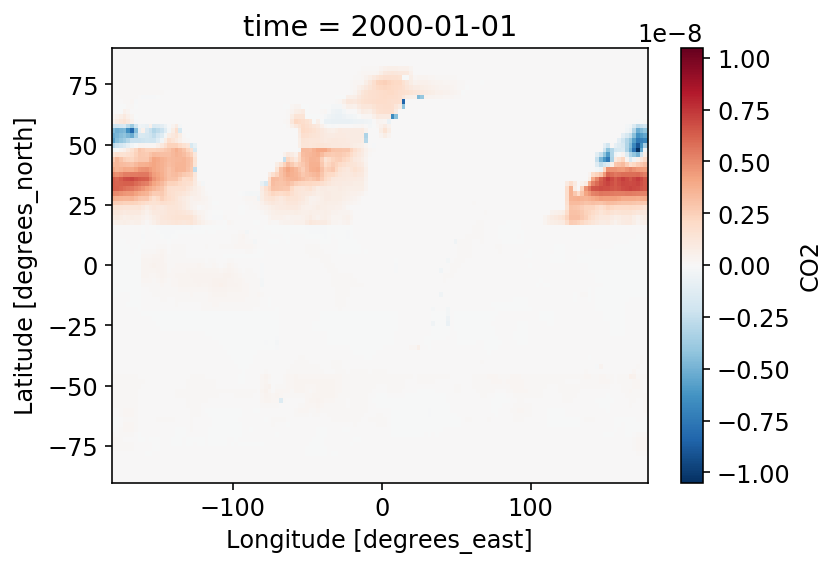

In [61]:
# check the updates
ds_before = xr.open_dataset(f2)
ds_after = xr.open_dataset(input_dir + 'Taka2009_CO2_Monthly.updated.' + str(year) + '.' + name_month + '.nc')

diff = ds_after - ds_before
diff['CO2'][0,:,:].plot()


In [22]:
%%time
# update biospheric flux
ds = xr.open_dataset(f1)
data = ds['CO2']

scale_map_regrid = data[0:lag_window].copy()
scale_map_regrid[:,:,:] = 0.
for i in range(lag_window):
    for ilon, lon in enumerate(scale_map_regrid['lon'].values):
        for ilat, lat in enumerate(scale_map_regrid['lat'].values):
            scale_map_regrid[i,ilat,ilon] = scale_map[i,:,:].sel(lat = lat, lon = lon, method="nearest")


CPU times: user 4min 1s, sys: 58.2 ms, total: 4min 1s
Wall time: 4min 1s


In [23]:
months = np.arange('2016-01', '2017-02', dtype='datetime64[M]')

#for i in range(lag_window):
#    imonth = assim_month - lag_window + i
for imonth in [-1]:
    if imonth < 0: imonth += 12
    print(months[imonth])
    before = data.sel(time = slice(months[imonth], months[imonth+1]))
    after  = data.sel(time = slice(months[imonth], months[imonth+1]))*scale_map_regrid[imonth-10,:,:]
    # assign this new subset into dataarray
    time_dim = before.time
    #print(time_dim.values)
    data.loc[dict(time = time_dim)] = after
ds_output = data.to_dataset(name = 'CO2')
ds_output.attrs = ds.attrs

ds_output.to_netcdf(input_dir + 'NEE.Liang.2016.updated.' + str(year) + '.' + name_month + '.nc')


2016-12


In [24]:

months = np.arange('2016-01', '2017-02', dtype='datetime64[M]')

f1_base = input_dir + 'NEE.Liang.2016.updated.' + str(year) + '.' + name_month + '.nc'
ds = xr.open_dataset(f1_base)
data = ds['CO2']
#imonth = 0

f1 = input_dir + 'NEE.Liang.2016.nc'
ds = xr.open_dataset(f1)
data_tmp = ds['CO2']

#for imonth in range(2,12):
for imonth in range(2):
    before = data_tmp.sel(time = slice(months[imonth], months[imonth+1]))
    after  = data_tmp.sel(time = slice(months[imonth], months[imonth+1]))*scale_map_regrid[imonth+1,:,:]

    time_dim = after.time
    print(time_dim.values)
    data.loc[dict(time = time_dim)] = after
    
ds_output = data.to_dataset(name = 'CO2')
ds_output.attrs = ds.attrs

ds_output.to_netcdf(input_dir + 'NEE.Liang.2016.updated.' + str(year) + '.' + name_month + '.nc')



['2016-01-01T00:00:00.000000000' '2016-01-01T03:00:00.000000000'
 '2016-01-01T06:00:00.000000000' '2016-01-01T09:00:00.000000000'
 '2016-01-01T12:00:00.000000000' '2016-01-01T15:00:00.000000000'
 '2016-01-01T18:00:00.000000000' '2016-01-01T21:00:00.000000000'
 '2016-01-02T00:00:00.000000000' '2016-01-02T03:00:00.000000000'
 '2016-01-02T06:00:00.000000000' '2016-01-02T09:00:00.000000000'
 '2016-01-02T12:00:00.000000000' '2016-01-02T15:00:00.000000000'
 '2016-01-02T18:00:00.000000000' '2016-01-02T21:00:00.000000000'
 '2016-01-03T00:00:00.000000000' '2016-01-03T03:00:00.000000000'
 '2016-01-03T06:00:00.000000000' '2016-01-03T09:00:00.000000000'
 '2016-01-03T12:00:00.000000000' '2016-01-03T15:00:00.000000000'
 '2016-01-03T18:00:00.000000000' '2016-01-03T21:00:00.000000000'
 '2016-01-04T00:00:00.000000000' '2016-01-04T03:00:00.000000000'
 '2016-01-04T06:00:00.000000000' '2016-01-04T09:00:00.000000000'
 '2016-01-04T12:00:00.000000000' '2016-01-04T15:00:00.000000000'
 '2016-01-04T18:00:00.000

Feb


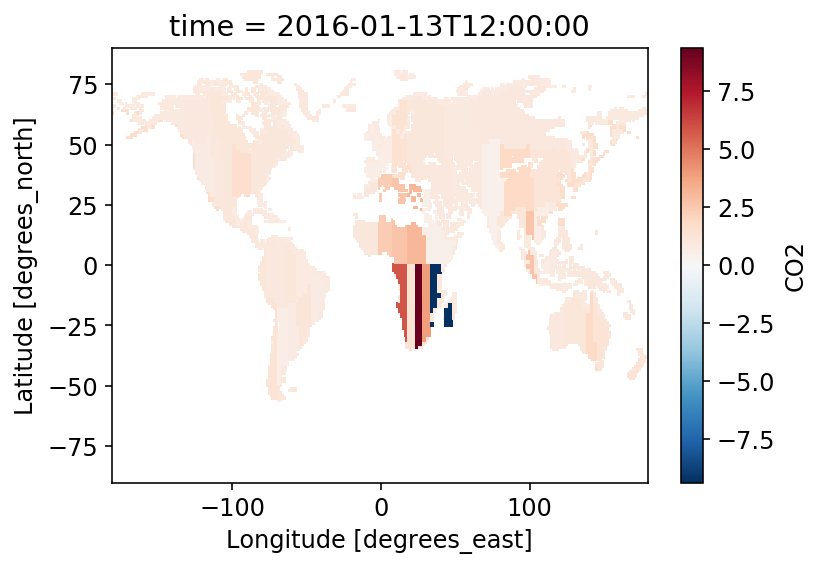

In [49]:
# check the updates
ds_before = xr.open_dataset(input_dir + 'NEE.Liang.2016.updated.' + str(year) + '.Jan.nc'
)
ds_after  = xr.open_dataset(input_dir + 'NEE.Liang.2016.updated.' + str(year) + '.' + name_month + '.nc')
print(name_month)
diff = ds_after/ds_before
diff['CO2'][100,:,:].plot()



In [26]:
np.savetxt('/scratch/local/msadiq/rundir/2017/CO2-2017/nd51/Mar2018/'+ "prior_error_" + short_name_of_month(assim_month+1) + ".txt", del_X_updated)


In [22]:
# updated prior error, save it in current and next month directory
if assim_month == 12:
    np.savetxt(next_dir + "prior_error_" + short_name_of_month(1) + ".txt", del_X_updated)
else:
    np.savetxt(next_dir + "prior_error_" + short_name_of_month(assim_month+1) + ".txt", del_X_updated)


In [ ]:
# check error
a = np.loadtxt(next_dir + "prior_error_" + short_name_of_month(assim_month+1) + ".txt")
np.diag(a)